In [109]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import os
import re
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

In [6]:
# Load Universal Sentence Encoder from TensorFlow Hub
model = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2")

In [90]:
def embed(sentences):
    return model(sentences)

In [91]:
df = pd.read_csv('data_recom.csv')
df.head()

,prompt,theme,type,shortdesc
0,cara belajar python,pemrograman,indoor,cara belajar Python dengan efektif dan memaham...
1,cara membaca buku efektif,pendidikan,indoor,memahami teknik efektif dalam membaca buku aga...
2,cara menulis catatan dengan benar,pendidikan,indoor,menulis catatan dengan benar untuk membantu me...
3,cara mengikuti kuliah online,pendidikan,indoor,mengikuti kuliah online dengan efektif dan men...
4,cara menyusun rencana pelajaran,pendidikan,indoor,menyusun rencana pelajaran yang efektif untuk ...


In [29]:
df = df[["prompt", "shortdesc"]]
df.head()

,prompt,shortdesc
0,cara belajar python,cara belajar Python dengan efektif dan memaham...
1,cara membaca buku efektif,memahami teknik efektif dalam membaca buku aga...
2,cara menulis catatan dengan benar,menulis catatan dengan benar untuk membantu me...
3,cara mengikuti kuliah online,mengikuti kuliah online dengan efektif dan men...
4,cara menyusun rencana pelajaran,menyusun rencana pelajaran yang efektif untuk ...


In [117]:
desc = list(df['prompt'])
desc[:10]
embeddings = embed(desc)

In [102]:
with open("embeddings_metadata.tsv", 'w', encoding='utf-8') as f:
    f.write("prompt\tembedding\n")  # Header row
    for label, embedding in zip(df['prompt'], embeddings.numpy()):
        embedding_str = '\t'.join(str(x) for x in embedding)
        f.write(f"{label}\t{embedding_str}\n")

In [119]:
embeddings = embed(desc)
print(embeddings.shape)

(479, 512)


In [121]:
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

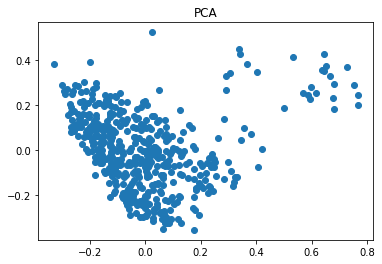

In [122]:
plt.title("PCA")
plt.scatter(emb_2d[:,0], emb_2d[:,1])
plt.show()

In [123]:
nn = NearestNeighbors(n_neighbors=5, metric='cosine')
nn.fit(embeddings)

NearestNeighbors(metric='cosine')

In [124]:
def recommend(text):
    emb = embed([text])
    neighbors = nn.kneighbors(emb, return_distance=False)[0]
    return df['prompt'].iloc[neighbors].tolist()

In [130]:
print('Recommended prompts:')
recommend("belajar memaafkan orang lain")

Recommended prompts:


['cara menjadi orang kaya',
 'belajar teknik anggar',
 'cara membuat kerajinan dari batu',
 'cara belajar bahasa asing',
 'cara memahami perkembangan bahasa pada anak usia dini']

In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\FX505\AppData\Local\Temp\tmpgzsq4go3\assets


INFO:tensorflow:Assets written to: C:\Users\FX505\AppData\Local\Temp\tmpgzsq4go3\assets


In [24]:
with open("universal_sentence_encoder.tflite", "wb") as f:
    f.write(tflite_model)